# Bias system analysis: $\texttt{COMBO_DM}$

In this notebook I try to use the nested sampling to recover the posterior distribution of the parameters of the binary system with a purposedly wrong template for an dark matter-only scenario. The evidence will be used in the Bayes factor calculation. 

### Import functions and stuff from pydd

In [1]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d

from pydd.analysis import get_match_pads
from pydd.binary import get_m_1, get_f_isco, get_m_2

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner
from scipy.interpolate import griddata
from scipy.stats import scoreatpercentile

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/pydd/binary.py:521: RuntimeWarning: invalid value encountered in log10
  vals_neg = np.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))


In [2]:
import environments_handy_functions

# Reload libraries (in case you change something)
import importlib
importlib.reload(environments_handy_functions)

from environments_handy_functions import (
    df_dt,  
    find_grid, 
    time_to_coal_cumul, 
    time_to_coal,
    phase_f_cumul, 
    f_1yr, 
    h_0, 
    mycalculate_SNR, 
    amplitude, 
    Psi,
    myVacuumBinary, myAccretionDisk, myDarkMatter, myCombination)

In [3]:
G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s

In [4]:
m1 = 1e5 * MSUN # kg
m2 = 10 * MSUN # kg

rho6 = 1.17e17 * MSUN / PC**3
r6 =  PC / 1e6
gammas = 7/3
epsv = 0.58

r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5e10 / Mach**2
alpha = -1/2

m_chirp = (m1 * m2)**(3/5) / (m1 + m2)**(1/5)

In [5]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "14"

### Select noise pattern

In [6]:
# Set detector
detector = "LISA"

In [7]:
# Set PSDs, choose observation time and SNR threshold (will set distance in signal system below)
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR 
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 1 * YR #seconds 
    SNR_THRESH = 100.0
    TITLE = "LISA"

### My version of $\texttt{get_signal_system}$

In [8]:
def myget_signal_system() -> Tuple[myVacuumBinary, myCombination, Tuple[float, float]]:
    
    m1 = 1e5 * MSUN # kg
    m2 = 10 * MSUN # kg
    
    rho6 = 1.17e17 * MSUN / PC**3
    r6 =  PC / 1e6
    gammas = 7/3
    epsv = 0.58
    
    r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
    r0 = 3 * r_s
    Mach = 100 
    sigma0 = 1.5e10 / Mach**2
    alpha = -1/2
    
    m_chirp = (m1 * m2)**(3/5) / (m1 + m2)**(1/5)
    
    _VB = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=100e6 * PC, 
    chirp_mass=m_chirp)
    
    q = _VB.q
    logL = np.log10(1 / q**(1/2))
    
    TT_C = 0.0 # time of coalescence
    F_C = _VB.frequency(6 * G * m1 / C**2)
    
    # m1, m2, dist, mach, sigma0, alpha, r0, chirp_mass, q, gammas, rho6, r6, epsv
    
    _COMBO = myCombination(m1=m1, 
                        m2=m2, 
                        dist=100e6 * PC, 
                        mach=Mach, 
                        sigma0=sigma0, 
                        alpha=alpha,
                        r0=r0,
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv, 
                        chirp_mass=m_chirp)

    # Frequency range and grids
    F_RANGE_D = find_grid(_COMBO, T_OBS)
    FS = np.linspace(max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 50_000)

    # Get dL such that SNR is as set above
    _fn = lambda dL: mycalculate_SNR(myCombination(m1=m1, 
                                                  m2=m2, 
                                                  dist=dL, 
                                                  mach=Mach, 
                                                  sigma0=sigma0, 
                                                  alpha=alpha,
                                                  r0=r0,
                                                  q=q, 
                                                  gammas=gammas, 
                                                  rho6=rho6, 
                                                  r6=r6, 
                                                  epsv=epsv, 
                                                  chirp_mass=m_chirp), FS[::-1], S_n)
    
    res = root_scalar(lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC))
    assert res.converged
    DL = res.root
    
    # Redefine DM and VB with "new" distance
    
    _COMBO_new = myCombination(m1=m1, 
                        m2=m2, 
                        dist=DL, 
                        mach=Mach, 
                        sigma0=sigma0,
                        alpha = alpha,
                        r0=r0,
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv, 
                        chirp_mass=m_chirp)
    
    _VB_new = myVacuumBinary(
    m1=m1,
    m2=m2,
    dist=DL, 
    chirp_mass=m_chirp)

    return _VB_new, _COMBO_new, F_RANGE_D

In [9]:
_VB, _COMBO, F_RANGE_D = myget_signal_system()

FS = np.linspace(F_RANGE_D[-1], F_RANGE_D[0], 3000) 

In [10]:
PAD_LOW, PAD_HIGH = get_match_pads(FS[::-1])  # padding for likelihood calculation

## Add waveform and noise patterns

For the moment, I am not going to use the $\texttt{get_frequency_noise}$ function, only defining it for further use. 

In [11]:
def get_frequency_noise(psd, fs):
    
    delta_f = fs[0] - fs[1]
    sigma = np.sqrt(psd(fs)/(4 * delta_f))
    not_zero = (sigma != 0)
    sigma_red = sigma[not_zero]
    noise_re = np.random.normal(0, sigma_red)
    noise_co = np.random.normal(0, sigma_red)

    noise_red = (1/np.sqrt(2)) * (noise_re + 1j * noise_co)

    noise = np.zeros(len(sigma), dtype=complex)
    noise[not_zero] = noise_red

    return noise

In [12]:
def waveform(params_h, fs, S_n):
    flen = len(fs)
    delta_f = fs[0] - fs[1]
    
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0))
    noise = get_frequency_noise(S_n, fs)
    
    wf_h_noise = wf_h + noise
    
    return wf_h, noise, wf_h_noise

In [13]:
# Define the signal: 

signal = waveform(_COMBO, FS, S_n)[0] # 0: noiseless, 1: noise-only, 2: noisy

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


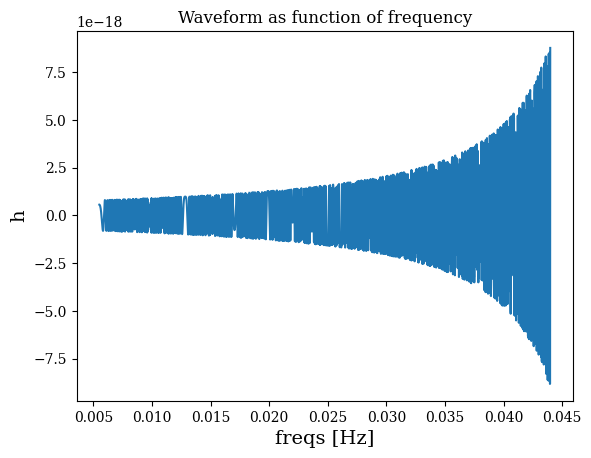

In [14]:
# see the waveform

plt.plot(FS[::-1], signal)
plt.xlabel('freqs [Hz]')
plt.ylabel('h')
plt.title('Waveform as function of frequency');

# Functions for likelihood calculation

In [15]:
def calculate_match_unnormd_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[0] - fs[1] # I have set out a reversed grid wr to the pydd version
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0)) # h is the model/template
    wf_d = signal # d is the signal including noise
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    return np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()


def loglikelihood_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Log-likelihood for a signal from a binary params_d modeled using params_h,
    maximized over the distance to the binary, Phi_c and t_c (i.e., all
    extrinsic parameters).
    """
    # Waveform magnitude
    ip_hh = mycalculate_SNR(params_h, fs, S_n) ** 2
    # Inner product of waveforms, maximized over Phi_c by taking absolute value
    ip_hd = calculate_match_unnormd_fft(params_h, params_d, fs, pad_low, pad_high, S_n)
    # Maximize over distance
    return 1 / 2 * ip_hd ** 2 / ip_hh

### Check 'max' likelihood 

In [16]:
maxll = loglikelihood_fft(_COMBO, _COMBO, FS, PAD_LOW, PAD_HIGH)
print(maxll) # check with different fs

5016.317880785245


In [17]:
# symmetric priors around true value

true_value = np.array([_COMBO.Binary_init.chirp_mass, _COMBO.DarkMatter_init.rho6, _COMBO.DarkMatter_init.gammas, _COMBO.Binary_init.q, _COMBO.Accretion_init.alpha, _COMBO.Accretion_init.sigma0])

print('true value list: ', true_value)

true value list:  [ 7.91640182e+32  7.91900727e-03  2.33333333e+00  1.00000000e-04
 -5.00000000e-01  1.50000000e+06]


In [18]:
# set smaller prior range

def ptform(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values. () brackets have flat prior choices.
    """
    assert u.shape == (4,)
    
    m_chirp = np.array([2 * (0.5) * (u[0]-0.5)])
    rho6 = np.array([np.log10(true_value[1]) - 0.01 + 2 * (0.1) * u[1]])
    gamma = np.array([2 * (0.2) * (u[2]-0.5)])
    q = np.array([np.log10(true_value[3]) - 0.1 + 2 * (0.06) * u[3]])
    
    return np.array([m_chirp, rho6, gamma, q]).reshape(4,) 


def unpack(x: np.ndarray) -> myDarkMatter:
    """
    Convenience function to unpack parameters into a dark dress.
    """
    dMc = x[0]
    drho6 = x[1] 
    dgamma = x[2]
    dq = x[3]
    
    Mc = _COMBO.Binary_init.chirp_mass + dMc * MSUN
    rho6 = 10**(drho6)
    gammas = _COMBO.DarkMatter_init.gammas + dgamma
    q = 10**(dq)
    
    m_1 = get_m_1(Mc, q)
    m_2 = get_m_2(Mc, q)
    
    DL = _COMBO.Binary_init.dist
    
    return myDarkMatter(m1=m_1, 
                        m2=m_2, 
                        dist=DL, 
                        q=q, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=_COMBO.DarkMatter_init.r6, 
                        epsv=_COMBO.DarkMatter_init.epsv, 
                        chirp_mass=Mc)

def get_ll_fft(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack(x)
    return loglikelihood_fft(ad_h, _COMBO, FS, PAD_LOW, PAD_HIGH, S_n)

In [19]:
xs = []
lls = []
for _ in trange(5000):
    xs.append(ptform(np.random.rand(4)))
    lls.append(get_ll_fft(xs[-1]))
              
xs = np.array(xs)
lls = np.array(lls)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [20]:
mtrue = 0
gamma_true = 0
logrho6_true = np.log10(_COMBO.DarkMatter_init.rho6)
logq_true = np.log10(_COMBO.Binary_init.q)

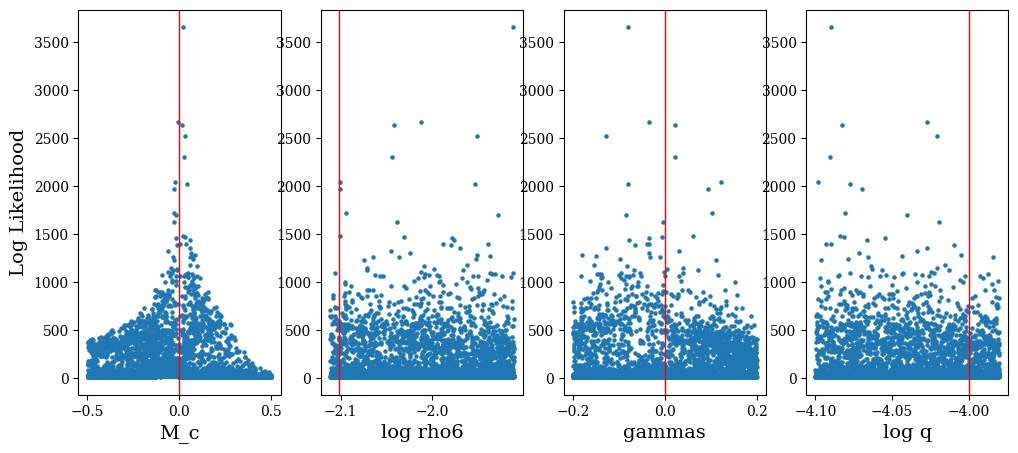

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(12, 5))

for i in range(0, 4): 

    ax[i].scatter(xs[:, i], lls, s=5)
    ax[i].set_title('')
    

ax[0].set_ylabel('Log Likelihood')

ax[0].set_xlabel('M_c')
ax[1].set_xlabel('log rho6')
ax[2].set_xlabel('gammas')
ax[3].set_xlabel('log q')

ax[0].axvline(x=mtrue, c='red', linewidth=1)
ax[1].axvline(x=logrho6_true, c='red', linewidth=1)
ax[2].axvline(x=gamma_true, c='red', linewidth=1)
ax[3].axvline(x=logq_true, c='red', linewidth=1);

# Results

In [22]:
with open('sampling-results/dm-results/sampling_results_dmVScombo.pkl', 'rb') as f:
    data_out = pickle.load(f)

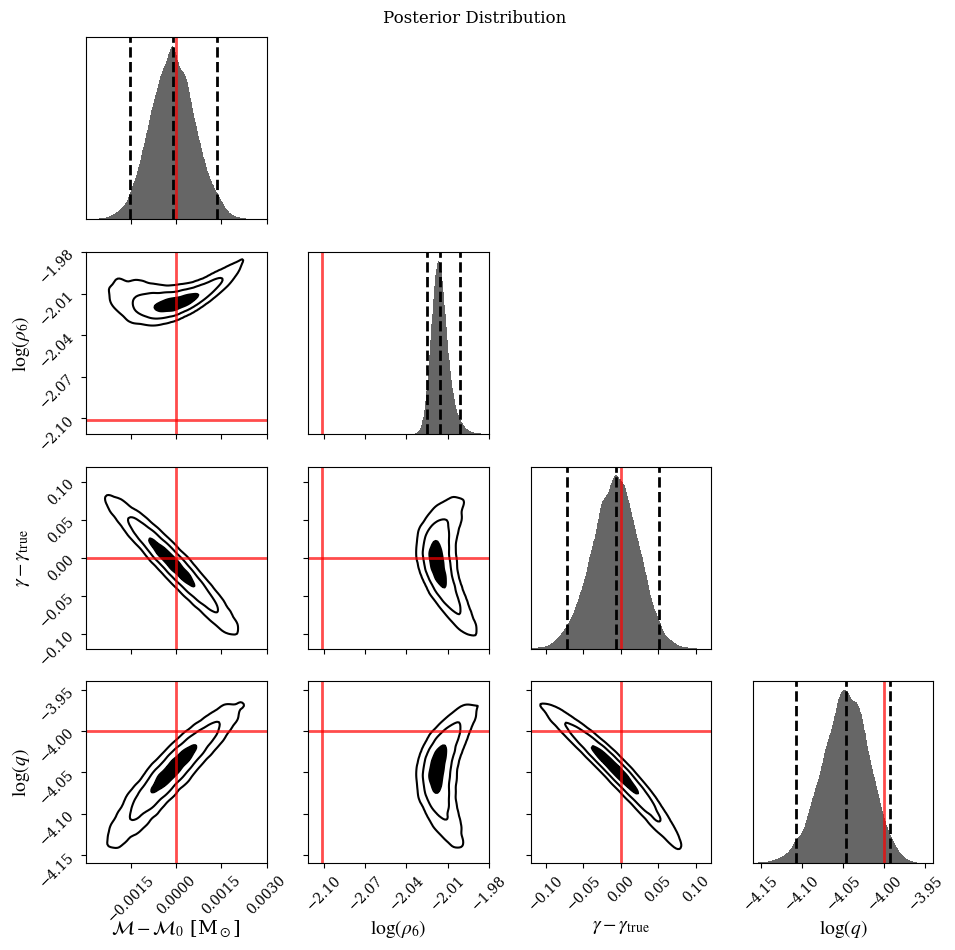

In [23]:
labels = [r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]", r"$\log(\rho_6)$", r'$\gamma - \gamma_{\mathrm{true}}$', r"$\log(q)$"]
truths=[mtrue, logrho6_true, gamma_true, logq_true] 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    data_out, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[mtrue, logrho6_true, gamma_true, logq_true],
    span=[(-0.003, 0.003), (logrho6_true - 0.01, -1.98), (-0.12, 0.12), (-4.16, -3.94)]
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()
plt.savefig('figures/COMBO_BIAS_dm.png')
plt.show()

## Extract best results

In [24]:
samples = data_out.samples  # shape: (n_samples, n_parameters)
weights = np.exp(data_out.logwt - data_out.logz[-1]) 

m_c_best = (np.sum(samples[:, 0] * weights) / np.sum(weights)) * MSUN + m_chirp
rho6_best = 10**(np.sum(samples[:, 1] * weights) / np.sum(weights))
gammas_best = (np.sum(samples[:, 2] * weights) / np.sum(weights)) + gammas
q_best = 10**(np.sum(samples[:, 3] * weights) / np.sum(weights))

m_1_best = get_m_1(m_c_best, q_best)
m_2_best = get_m_2(m_c_best, q_best)


_dm_best = myDarkMatter(m1=m_1_best, m2=m_2_best, dist=_COMBO.Binary_init.dist, q=q_best, gammas=gammas_best, r6=1e-6 * PC, rho6=rho6_best, epsv=_COMBO.DarkMatter_init.epsv, chirp_mass=m_c_best)

In [25]:
def calculate_match_NORMD_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[0] - fs[1] # I have set out a reversed grid wr to the pydd version
    
    # define the waveform and match
    
    wf_h = amplitude(fs, params_h) * np.exp(1j * Psi(fs, params_h, TTC=0.0, PHI_C=0.0)) 
    wf_d = amplitude(fs, params_d) * np.exp(1j * Psi(fs, params_d, TTC=0.0, PHI_C=0.0)) 
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    # Maximize over time shift using IFFT trick
    unnormalized_match = np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()
    
    # NEW!
    
    # Now calculate the normalization terms with self-inner products
    inner_product_hh = 4 * wf_h.conj() * wf_h / Sns * df
    inner_product_hh_padded = np.concatenate((pad_low, inner_product_hh, pad_high))
    norm_h = np.abs(len(inner_product_hh_padded) * np.fft.ifft(inner_product_hh_padded)).max()

    inner_product_dd = 4 * wf_d.conj() * wf_d / Sns * df
    inner_product_dd_padded = np.concatenate((pad_low, inner_product_dd, pad_high))
    norm_d = np.abs(len(inner_product_dd_padded) * np.fft.ifft(inner_product_dd_padded)).max()

    # Normalize the match to be from 0 to 1
    normalized_match = unnormalized_match / np.sqrt(norm_h * norm_d)
    
    return normalized_match

In [26]:
def mismatch(params_h, params_d, fs, pad_low, pad_high, S_n=S_n):
    '''Returns waveforms (different in integration methods) mismatch as a number between 0 and 1. 0 means low mismatch, 1 means high mismatch.'''
    return 1 - calculate_match_NORMD_fft(params_h, params_d, fs, pad_low, pad_high, S_n=S_n)

In [27]:
print('mismatch with best', mismatch(_COMBO, _dm_best, FS, PAD_LOW, PAD_HIGH, S_n=S_n))

mismatch with best 0.6671443775616605


---

# 1D mismatch  

In [42]:
# check with some values:

m_range = np.linspace(m_chirp/MSUN - 2, m_chirp/MSUN + 2, 1000) * MSUN
logrho6_range = np.linspace(-4, -1, 1000)
gammas_range = np.linspace(1, 2.6, 1000)
logq_range = np.linspace(-5.5, -1.5, 1000)

m_1_range = get_m_1(m_range, q_best)
m_2_range = get_m_2(m_range, q_best)

In [29]:
# m_c

dm_mc = [myDarkMatter(m1=m_1_range[i], m2=m_2_range[i], dist=_COMBO.Binary_init.dist, 
                      q=q_best, gammas=gammas_best, r6=1e-6 * PC, rho6=rho6_best, 
                      epsv=_COMBO.DarkMatter_init.epsv, chirp_mass=m_range[i]) for i in range(0, len(m_range))]

In [30]:
# find mismatch

mis_mc = [mismatch(dm_mc[i], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(m_range))]

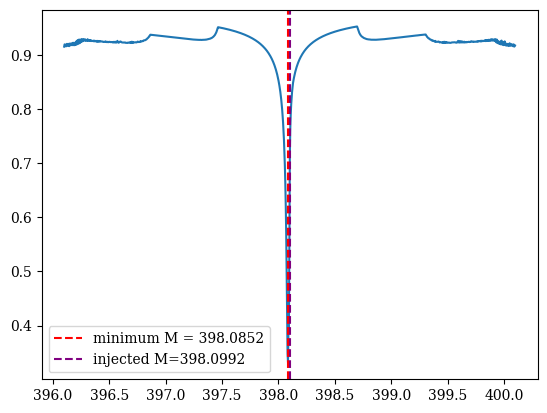

In [31]:
plt.plot(m_range/MSUN, mis_mc)
plt.axvline(x=m_range[np.where(mis_mc == np.min(mis_mc))[0][0]]/MSUN, c='red', linestyle='--', label=f'minimum M = {m_range[np.where(mis_mc == np.min(mis_mc))[0][0]]/MSUN:.4f}')
plt.axvline(x=m_chirp/MSUN, c='purple', label=f'injected M={m_chirp/MSUN:.4f}', linestyle='--')
plt.legend(loc='lower left')
#plt.xlim(397.3, 398.7)
plt.show()

In [32]:
# rho6

dm_rho6 = [myDarkMatter(m1=m_1_best, m2=m_2_best, dist=_COMBO.Binary_init.dist, 
                      q=q_best, gammas=gammas_best, r6=1e-6 * PC, rho6=10**(logrho6_range[i]), 
                      epsv=_COMBO.DarkMatter_init.epsv, chirp_mass=m_c_best) for i in range(0, len(m_range))]

In [33]:
# find mismatch

mis_rho6 = [mismatch(dm_rho6[i], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(m_range))]

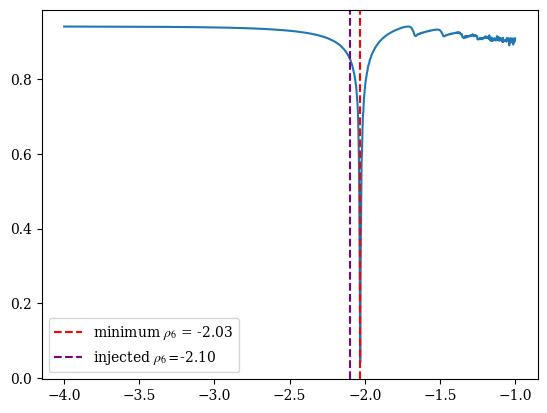

In [34]:
plt.plot(logrho6_range, mis_rho6)
plt.axvline(x=logrho6_range[np.where(mis_rho6 == np.min(mis_rho6))[0][0]], c='red', linestyle='--', label=fr'minimum $\rho_6$ = {logrho6_range[np.where(mis_rho6 == np.min(mis_rho6))[0][0]]:.2f}')
plt.axvline(x=np.log10(rho6), c='purple', label=fr'injected $\rho_6 =${np.log10(rho6):.2f}', linestyle='--')
plt.legend(loc='lower left')

plt.show()

In [47]:
# gammas

dm_gammas = [myDarkMatter(m1=m_1_best, m2=m_2_best, dist=_COMBO.Binary_init.dist, 
                      q=q_best, gammas=gammas_range[i], r6=1e-6 * PC, rho6=rho6_best, 
                      epsv=_COMBO.DarkMatter_init.epsv, chirp_mass=m_c_best) for i in range(0, len(m_range))]

In [48]:
# find mismatch

mis_gammas = [mismatch(dm_gammas[i], _COMBO, FS, PAD_LOW, PAD_HIGH, S_n=S_n) for i in range(0, len(m_range))]

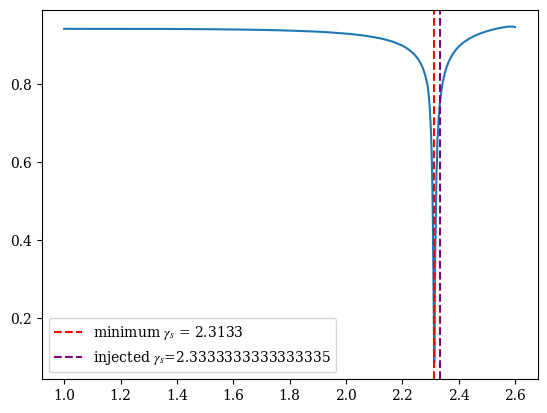

In [49]:
plt.plot(gammas_range, mis_gammas)
plt.axvline(x=gammas_range[np.where(mis_gammas == np.min(mis_gammas))[0][0]], c='red', linestyle='--', label=f'minimum $\gamma_s$ = {gammas_range[np.where(mis_gammas == np.min(mis_gammas))[0][0]]:.4f}')
plt.axvline(x=gammas, c='purple', label=fr'injected $\gamma_s$={gammas}', linestyle='--')
plt.legend(loc='lower left')

plt.show()